<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations. 

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height. 

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [14]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. 

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [15]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 2000 * kilometer # The domain size
Nx = 1024 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1) 
H.change_scales(1) 
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-20 08:10:54,589 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
2024-12-20 08:10:54,590 __main__ 0/1 INFO :: Starting main loop
2024-12-20 08:10:54,770 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-20 08:10:54,770 solvers 0/1 INFO :: Final iteration: 100
2024-12-20 08:10:54,771 solvers 0/1 INFO :: Final sim time: 6000.0
2024-12-20 08:10:54,771 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05559 sec
2024-12-20 08:10:54,771 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04486 sec
2024-12-20 08:10:54,771 solvers 0/1 INFO :: Run time (iter 10-end): 0.1349 sec
2024-12-20 08:10:54,772 solvers 0/1 INFO :: CPU time (iter 10-end): 3.748e-05 cpu-hr
2024-12-20 08:10:54,772 solvers 0/1 INFO :: Speed: 2.73e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

2024-12-20 08:10:54,820 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-20 08:10:54,821 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmppq7etf9z/temp.m4v


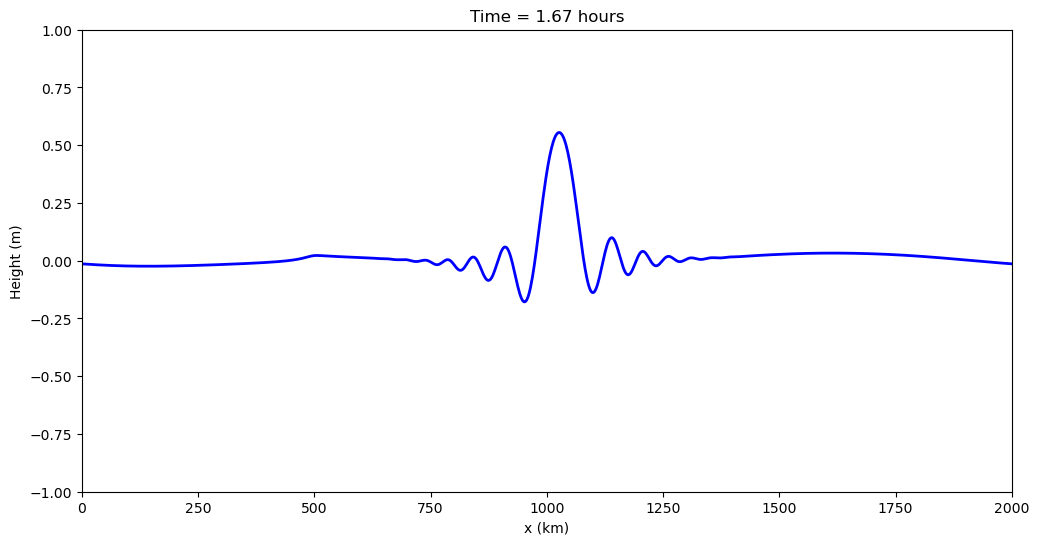

In [16]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))            
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)    

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value. 

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE:

**The Shallow Water Equations in 2D are:**
$$ \partial_t u + u \partial_x u + v \partial_y i - f v = - g \partial_x \eta $$
$$ \partial_t v + u \partial_x v + v \partial_y v + f u = - g \partial_y \eta $$
$$ \partial_t \eta + \partial_x (u(H_0+\eta - h_b)) + \partial_y (v(H_0+\eta - h_b)) = 0 $$ 
**Assuming $Ro>>1$, $h_b=0$ and $u,v,\eta$ are small, then in one dimension (i.e. $\partial_y = 0$, we can get the wave equation.**
**As** 
$$ \partial_t u = - g \partial x \eta $$ 
$$ \partial_t v = 0 $$ 
$$ \partial_t \eta + H_0 \partial_x u = 0 $$ 
$$ \Rightarrow \partial_t^2 \eta - g H_0 \partial_x^2 \eta = 0 $$
**We can then find solutions of the form:**
$$ \eta(x,t) = \eta_0 \cos(kx - \omega t) $$
**where $\omega = \sqrt{gH_0}k$.**
**The wave sped is then given by $\omega/k = \sqrt{gH_0}$.** 

**The above assumptions are not true in our case. Specifically, $h_b$ is not zero. Instead we can express the equations as:**
$$ \partial_t u = - g \partial_x \eta $$
$$ \partial_t \eta + \partial_x (u (H_0 - h_b) )= 0 $$ 
**By the product rule, the derivative:**
$$ \partial_x (u (H_0 - h_b) ) = u \partial_x (H_0 - h_b) + (H_0 - h_b) \partial_x u $$ 
**Assuming the bottom varies slowly:** 
$$ = (H_0 - h_b) \partial_x u $$ 
**The wave equation is then:** 
$$ \Rightarrow \partial_t^2 \eta - g (H_0 - h_b) \partial_x^2 \eta = 0 $$   
**So the wave speed is $ \sqrt{g(H_0 - h_b)} $** 

[214843.75  214843.75  220703.125 230468.75  242187.5   253906.25
 265625.    275390.625 287109.375 298828.125 310546.875 322265.625
 332031.25  343750.    353515.625 365234.375 375000.    384765.625
 394531.25  404296.875 414062.5   421875.    429687.5   435546.875
 443359.375 449218.75  453125.    458984.375 462890.625 466796.875
 470703.125 474609.375 478515.625 480468.75  482421.875 486328.125
 488281.25  490234.375 492187.5   494140.625 496093.75  498046.875
 500000.    501953.125 503906.25  505859.375 507812.5   509765.625
 511718.75  513671.875 517578.125 519531.25  523437.5   527343.75
 531250.    535156.25  541015.625 546875.    552734.375 558593.75 ]
[  0.          97.65625    162.76041667 195.3125     195.3125
 195.3125     162.76041667 195.3125     195.3125     195.3125
 195.3125     162.76041667 195.3125     162.76041667 195.3125
 162.76041667 162.76041667 162.76041667 162.76041667 162.76041667
 130.20833333 130.20833333  97.65625    130.20833333  97.65625
  65.10416667  9

(0.0, 2000.0)

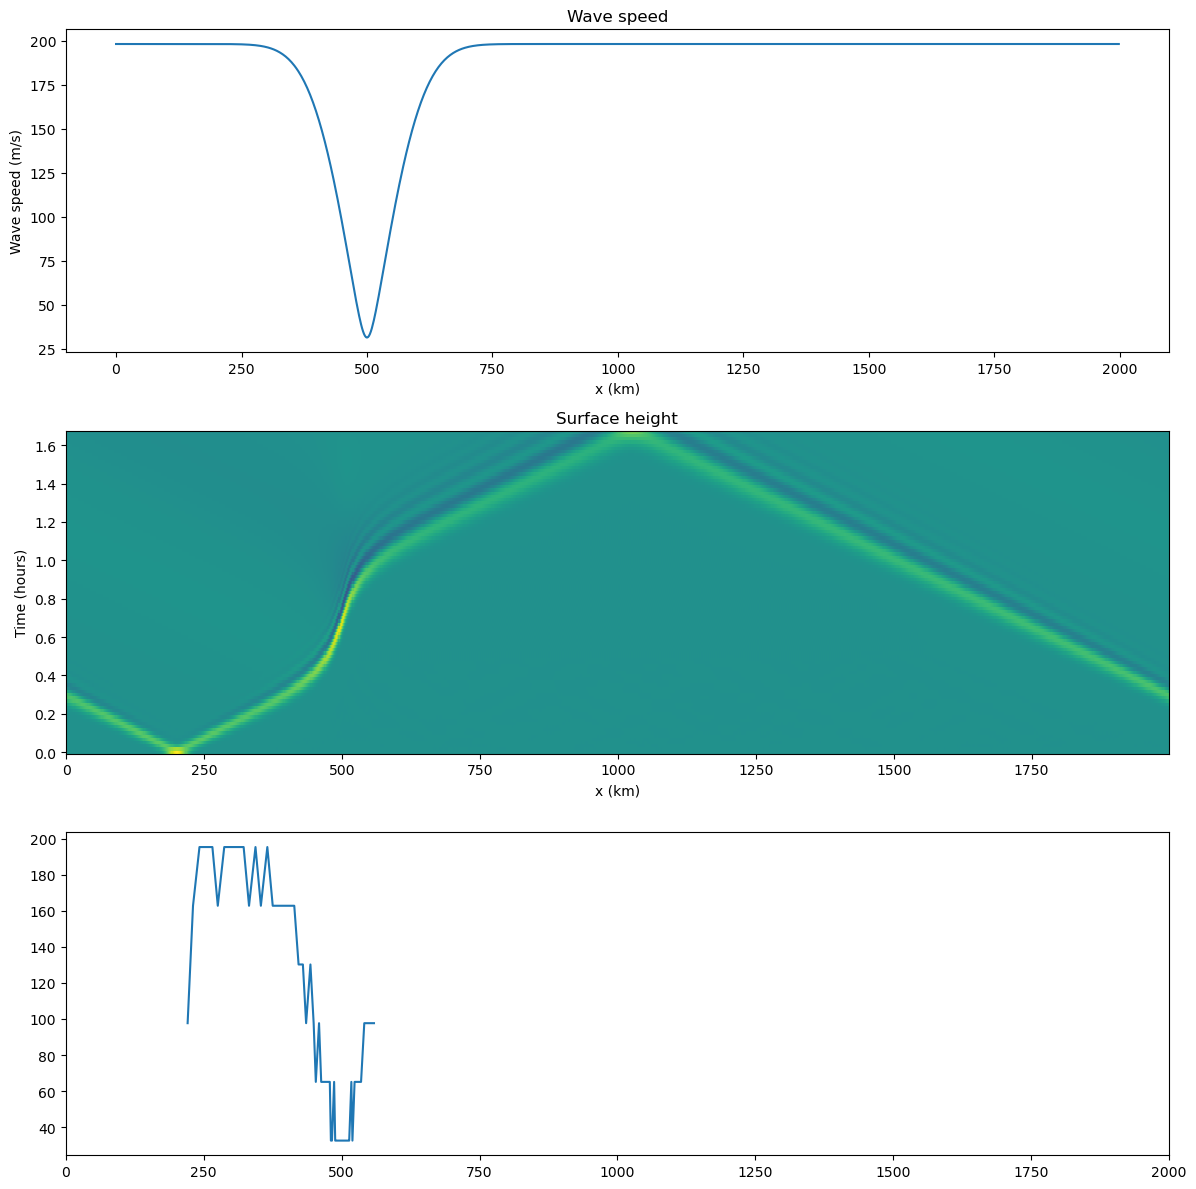

In [17]:
# Make 3 vertical subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
# Calculate and plot the wave speed across x.
wave_speed = np.sqrt(g*(H['g']))
ax1.plot(x/(1*kilometer), wave_speed) 
ax1.set_xlabel('x (km)')
ax1.set_ylabel('Wave speed (m/s)')
ax1.set_title('Wave speed')
# Plot the position of the wave vs time using the wave speed

# Plot the movement of the wave on a heatmap with t: 
ax2.pcolormesh(x/(1*kilometer), np.array(t_save)/(1*hour), h_save, vmin=-1, vmax=1)
#ax2.plot(x/(1*kilometer), (x/1*kilometer)/wave_speed, 'k--')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('Time (hours)')
ax2.set_title('Surface height')

plt.tight_layout() 

# TODO:// FIX this! 
# calculate the wave spead from peak x 
peak_x = x[np.argmax(h_save[:60,111:], axis=1) + 110]
print(peak_x)
wave_speed_peak = np.diff(peak_x)/timestep 
ax3.plot(peak_x[2:]/(1*kilometer), wave_speed_peak[1:]) 
print(wave_speed_peak)
# make sure the x axis is the same 
plt.xlim((0, Lx / (1*kilometer)))


COMMENT ON RESULTS
**The calculated wave speed very closely matches the theoretical velocity. The spikiness in the plot is an artifact of the discrete nature of selecting a maximum point for each timestep.** 

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [18]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-20 08:11:01,073 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:01,093 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-20 08:11:01,119 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-12-20 08:11:01,144 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-12-20 08:11:01,173 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-12-20 08:11:01,201 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-12-20 08:11:01,228 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-12-20 08:11:01,255 subsystems 0/1 INFO :: Building subproblem matric

### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-20 08:11:01,675 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-20 08:11:01,675 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp40xadbzs/temp.m4v


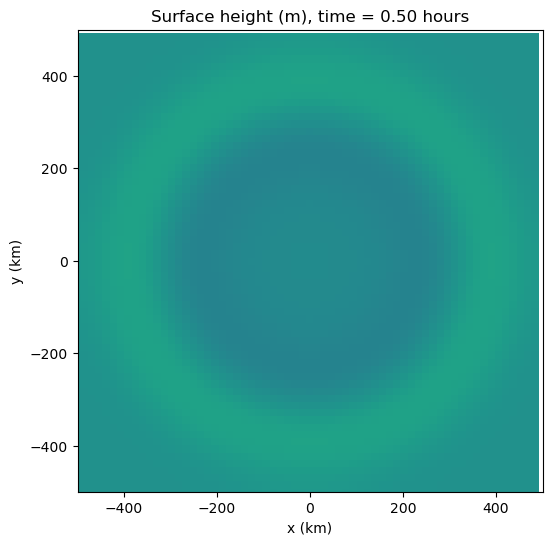

In [19]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation. 

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations)

**Using conservation of energy per unit area:**
$$ KE = \int_{h_b}^{H_0+\eta} \frac 12 \rho (u2 + v2) dz $$ 
$$ = \frac 12 \rho (u^2 + v^2) (H_0 + \eta - h_b) $$ 

**KE is small compared to PE as $u,v$ are small. At $t_0$ PE starts proportional to $H_0^2$.**

$$ PE = \int_{h_b}^{H_0+\eta} \rho g z dz $$
$$ = \rho g \frac{(H_0+\eta)^2 - h_b^2}{2} $$
$$ \frac{2 PE}{\rho g} = (H_0 + \eta)^2 - h_b^2 $$ 
$$ \sqrt{\frac{2 PE}{\rho g} + h_b^2} - H_0 = \eta$$

**In these terms, $h_b$ is 0, and only the PE depends on distance from the origin. The energy at a point on the wavefront scales as 1/r since it is being spread to a distance of $2\pi r$. $\rho$ is 1. Therefore as a function of radius:**
$$ \eta(r) = \sqrt{\frac{PE_0}{\pi r g}} - H_0 $$


**Amplitude is proportional to $\frac{A_0}{\sqrt{r}}$ where $A_0$ is the initial amplitude and $r$ is the distance from the source,** 
i.e. $\eta \sim \frac{H_0^2}{\sqrt{x^2 + y^2}}$

**In the plot below, I arbritrarily determined the coefficient by scaling to match at time 0. Due to our resolution, I also linearly interpolated between 0 and the first non-zero value of distance (as I took the distance from the origin from the simulation, rather than theoretically calculating the wavespeed.)**

/tmp/ipykernel_218806/2944098263.py:19: RuntimeWarning: divide by zero encountered in divide
  theoretical_amplitude = 1000/ np.sqrt(distances)


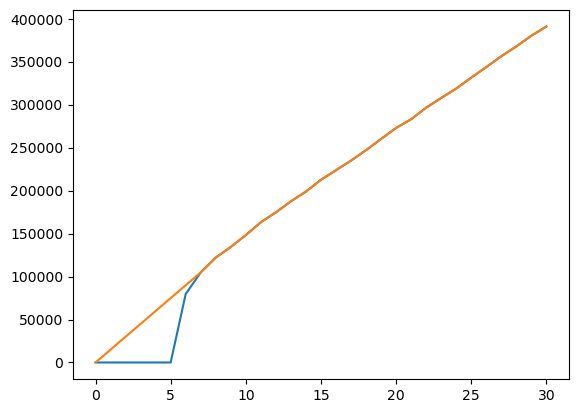

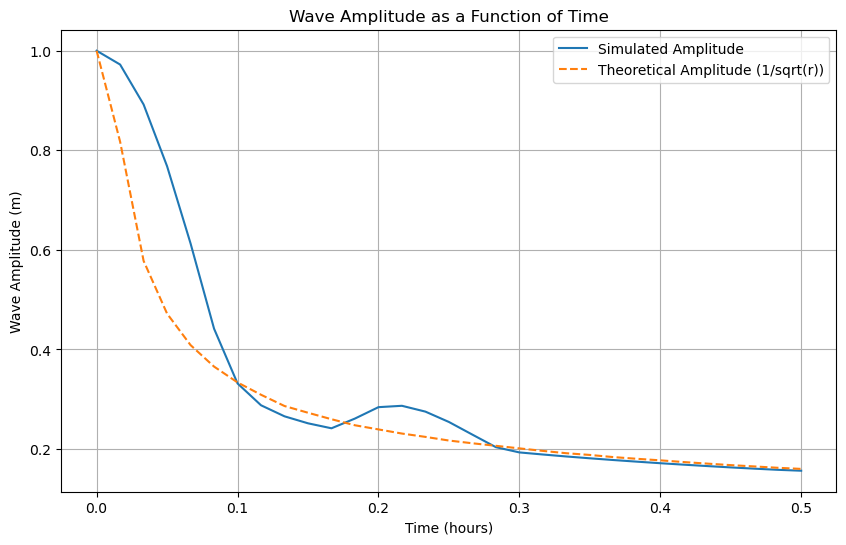

In [20]:
# Calculate the maximum amplitude of the wave at each time step
max_amplitude = np.max(np.abs(h_save), axis=(1, 2))
# Find the location of the maximum amplitude in both x and y at each time step.
max_amplitude_location = []
for index, t in enumerate(t_save):
    max_amplitude_location.append(np.unravel_index(np.argmax(h_save[index], axis=None), h_save[0].shape))

# Calculate the straight line distance from the origin
distances = np.sqrt((np.array(max_amplitude_location)[:, 0] / Nx * Lx - Lx / 2)**2 + 
                    (np.array(max_amplitude_location)[:, 1] / Ny * Ly - Ly / 2)**2)

# Interpolate from 0 to the first non-zero value in distances
plt.plot(distances)
first_non_zero_index = np.argmax(distances > 100000)
distances[:first_non_zero_index+1] = np.linspace(0, distances[first_non_zero_index], first_non_zero_index+1)

plt.plot(distances)
# Calculate the theoretical amplitude of the wave at each time step
theoretical_amplitude = 1000/ np.sqrt(distances) 
theoretical_amplitude /= 10 #arbritary scale
theoretical_amplitude[0] = 1
# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.array(t_save) / hour, max_amplitude, label='Simulated Amplitude')
plt.plot(np.array(t_save) / hour, theoretical_amplitude, label='Theoretical Amplitude (1/sqrt(r))', linestyle='--')
plt.xlabel('Time (hours)')
plt.ylabel('Wave Amplitude (m)')
plt.title('Wave Amplitude as a Function of Time')
plt.legend()
plt.grid(True)
plt.show()

ADD DISCUSSION HERE (~1 paragraph)

In [21]:
# Import the required packages
def simulate2D(hfunc):
    logger = logging.getLogger(__name__)

    # Define the simulation units. This is optional, but will help us keep track of units
    meter = 1
    kilometer = meter * 1e3
    second = 1
    minute = 60
    hour = 3600
    day = hour * 24

    # Specify the simulation parameters
    Lx = 1000 * kilometer # The domain size in x
    Ly = 1000 * kilometer # The domain size in y
    Nx = 64 # The number of gridpoints in x
    Ny = 64 # The number of gridpoints in y
    g = 9.81 * meter / second**2 # Gravitational acceleration
    H = 4 * kilometer # Reference ocean depth
    width = 100 * kilometer # Set the width of the initial Gaussian

    timestep = 60 * second # Specify the timestep
    stop_sim_time = 30 * minute # Specify the stopping time

    timestepper = dedalus.RK222
    max_timestep = 0.125

    # Bases
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
    ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    v = dist.Field(name='v', bases=(xbasis, ybasis))
    h = dist.Field(name='h', bases=(xbasis, ybasis))

    # Initial conditions
    h.change_scales(1) # Set values on regular grid
    u.change_scales(1)
    v.change_scales(1)
    h['g'] = hfunc  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
    u['g'] = 0
    v['g'] = 0

    # Operators
    dx = lambda a: dedalus.Differentiate(a, coords['x'])
    dy = lambda a: dedalus.Differentiate(a, coords['y'])

    # Problem
    problem = dedalus.IVP([u, v, h], namespace=locals())
    problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
    problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
    problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Analysis
    snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
    snapshots.add_task(h, name='h')
    snapshots.add_task(u, name='u')
    snapshots.add_task(v, name='v')

    h.change_scales(1)
    h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 1 == 0:
                h.change_scales(1)
                h_save.append(np.copy(h['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
    return h_save,t_save

2024-12-20 08:11:11,996 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-20 08:11:12,017 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-20 08:11:12,049 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-20 08:11:12,076 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-20 08:11:12,101 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-20 08:11:12,128 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-20 08:11:12,153 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-12-20 08:11:12,178 subsystems 0/1 INFO :: Building subproblem matric

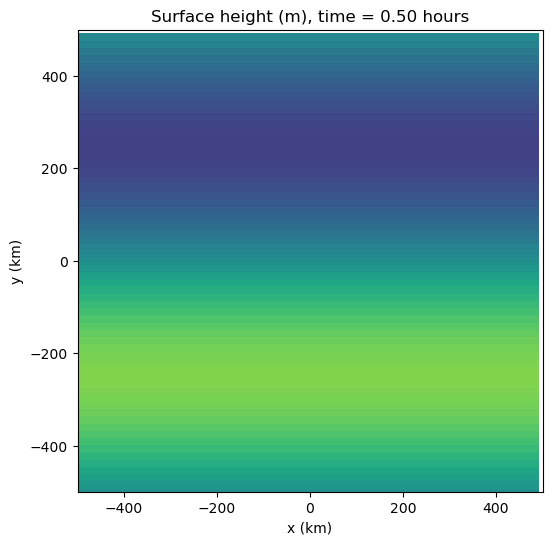

In [22]:
from dedalus.extras import plot_tools
from matplotlib import animation
from IPython.display import HTML

width = 200 * kilometer
# gaussian, t_save = simulate2D(np.exp(-(x**2+y**2)/width**2))
# gaussianX = simulate2D(np.exp(-(x**2)/width**2))
# cylinder, t_save = simulate2D(x**2 + y**2 <= width**2)
sin,t_save = simulate2D(np.sin(2*np.pi*x/(Lx)))

fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

# blit=True re-draws only the parts that have changed.
h_save = sin
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)
HTML(anim.to_html5_video())

**Using square/cylindrical waves shows that sharp boundaries are quickly smoothed out, with a lot of amplitude reduction. Obviously, symmetries are maintained.  Widening the wave emphasises the dispersal effect, and provides a longer wavelength. Altering the height simply changes tha amplitude.** 

**sinusoidal waves periodic on the domain alternate sign with time.** 

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. 

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [23]:
def sphereWave(omega): # Import the required packages
    import numpy as np
    import dedalus.public as dedalus
    import logging
    import matplotlib.pyplot as plt

    logger = logging.getLogger(__name__)

    # Define the simulation units. This is optional, but will help us keep track of units
    meter = 1
    kilometer = meter * 1e3
    second = 1
    minute = 60
    hour = 3600
    day = hour * 24

    # Parameters
    Nphi = 128 # Number of gridpoints in phi (longitude)
    Ntheta = 64 # Number of gridpoints in theta (colatitude)
    R = 6.37122e3 * kilometer
    Omega = omega
    #Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
    g = 9.80616 * meter / second**2 # Gravitational acceleration
    H = 4 * kilometer # Depth of the ocean
    width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
    phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
    theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

    timestep = 600 * second
    stop_sim_time = 10 * day

    # Bases
    coords = dedalus.S2Coordinates('phi', 'theta')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

    # Define the coordinates
    phi, theta = dist.local_grids(basis) # Longitude and colatitude
    lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

    # Fields
    u = dist.VectorField(coords, name='u', bases=basis)
    h = dist.Field(name='h', bases=basis)

    # Operators
    # First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
    # The "skew" operator performs a 90 degree rotation of a vector field,
    # so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
    zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

    # Set the initial conditions
    h.change_scales(1) # Set values on regular grid
    u.change_scales(1)
    h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
    # Set the initial velocity to zero
    u['g'][0] = 0 # the x-component of the velocity
    u['g'][1] = 0 # the y-component of the velocity

    # Problem
    problem = dedalus.IVP([u, h], namespace=locals())
    problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
    problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    h.change_scales(1)
    h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                h.change_scales(1)
                h_save.append(np.copy(h['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
    h_save = np.array(h_save)

    return h_save, phi, theta, t_save

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-20 08:11:22,892 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 9.3e+01/s
2024-12-20 08:11:22,941 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:23,000 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:23,060 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:23,121 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:23,182 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:23,242 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:11:23,299 subsystems 0/1 INFO :: Building subproblem matri

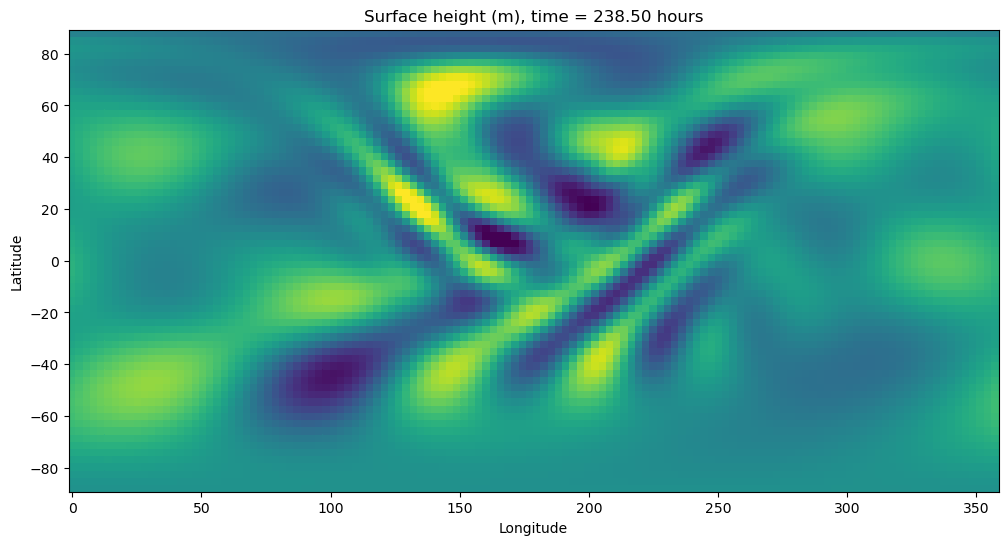

In [24]:
h_save,phi,theta,t_save= sphereWave(2*np.pi/(1*day))
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

2024-12-20 08:12:27,018 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:12:27,050 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+02/s
2024-12-20 08:12:27,086 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-12-20 08:12:27,123 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2024-12-20 08:12:27,158 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2024-12-20 08:12:27,195 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2024-12-20 08:12:27,232 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2024-12-20 08:12:27,268 subsystems 0/1 INFO :: Building subproblem matri

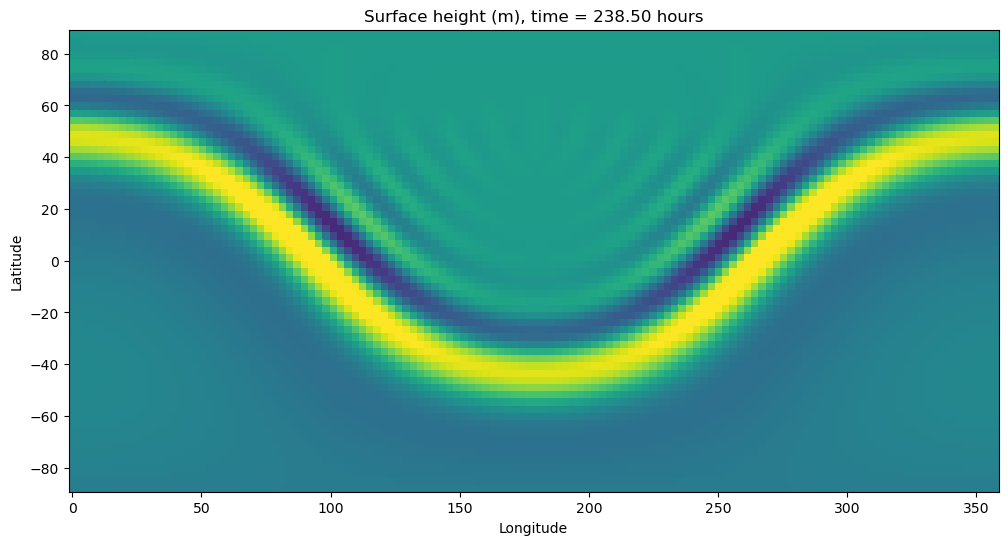

In [25]:
#The same with no rotation
h_NoRot ,phi,theta,t_save = sphereWave(0)
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_NoRot[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

48 96
(145, 128, 64)


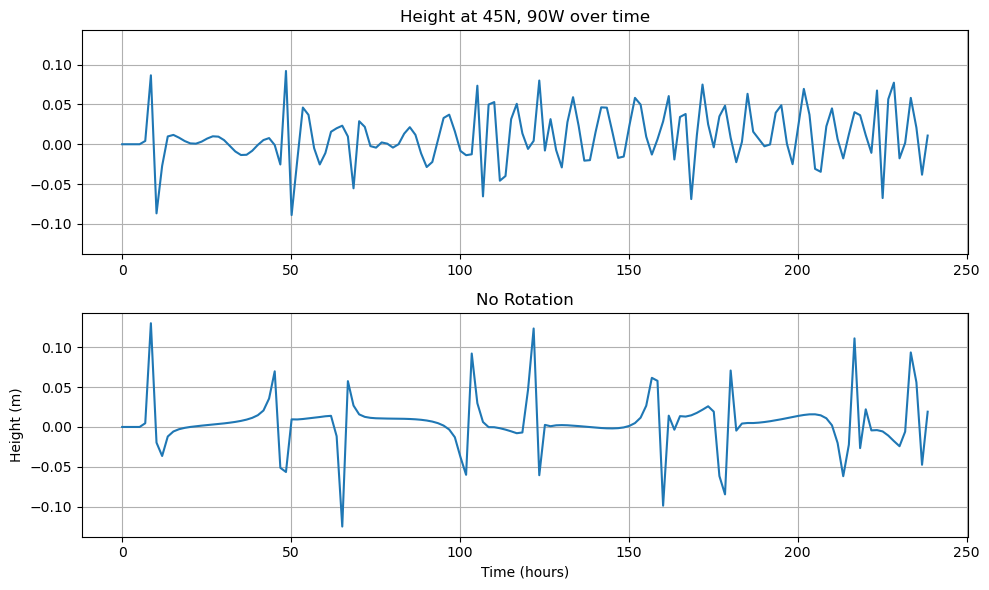

In [26]:

lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees
# Find the indices for the latitude 45N and longitude 90W
lat_index = np.argmin(np.abs(lat - 45))
long_index = np.argmin(np.abs(phi - (3 * np.pi / 2)))

print(lat_index,long_index)
print(h_save.shape)
# Sample the height at the specified latitude and longitude across time
height_timeseries = h_save[:, long_index, lat_index]
height_no_rot_time = h_NoRot[:, long_index,lat_index]
# Plot the timeseries
fig, axs = plt.subplots(figsize=(10, 6),nrows=2,sharey=True)
axs[0].plot(np.array(t_save) / hour, height_timeseries)
axs[1].plot(np.array(t_save) / hour, height_no_rot_time)
axs[1].set_title("No Rotation")
plt.xlabel('Time (hours)')
plt.ylabel('Height (m)')
axs[0].set_title('Height at 45N, 90W over time')
for ax in axs:
    ax.grid(True)
plt.tight_layout()
plt.show()



**The majority of the change in wave shape is due to the rotation of the Earth adding an extra vector to the velocity which assymetrically changes the propagation of the circular wave and therefore its shape.** 
**Additionally, though, the interaction of the opposite sides of the wave (i.e. when the radius goes to 0 at the other side of the planet), causes the amplitude to decrease and produce some oscillatory motion following the wave travel. This is reminiscent of Russell's solitary wave being overtaken by another solitary wave.**

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [27]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)
damping = dist.Field(name='damping', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

tau = 0.1 * day
damping['g'] = (-1/tau) *(0.5 * (1 + np.tanh((phi - 3 * np.pi / 2) / (np.pi / 10))) + 0.5 * (1 - np.tanh((phi - np.pi / 2) / (np.pi / 10))))


# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) + damping * h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
h_save = np.array(h_save)

# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

2024-12-20 08:13:32,241 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 9.4e+01/s
2024-12-20 08:13:32,288 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:13:32,346 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:13:32,401 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:13:32,459 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:13:32,517 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:13:32,571 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-20 08:13:32,626 subsystems 0/1 INFO :: Building subproblem matri

2024-12-20 08:14:23,319 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-20 08:14:23,320 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6oy__7j4/temp.m4v


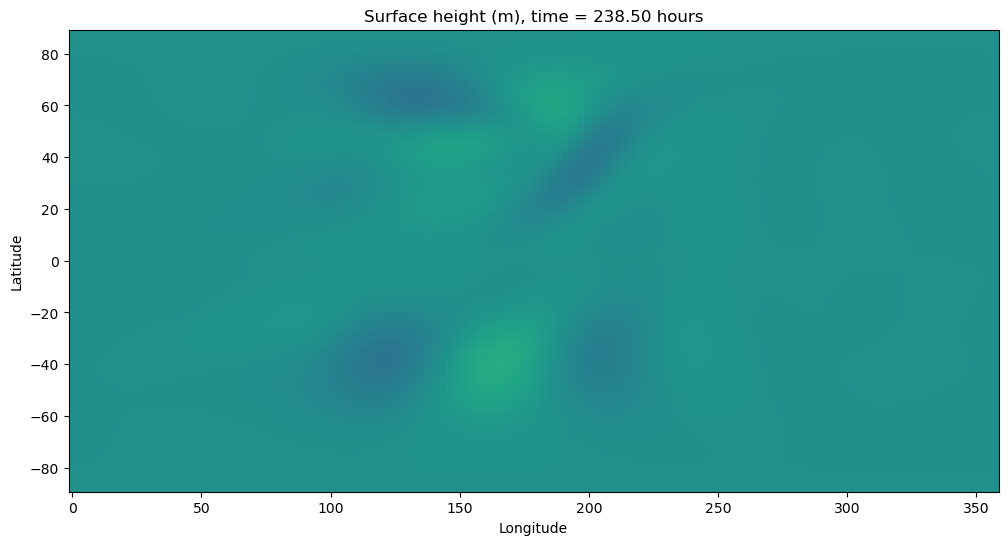

In [28]:
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**Spatially, the Rossby waves have a Westward flow as expected. They additionally have a meridonal wavenumber, i.e. they appear diagonal (despite having no motion in the N/S direction)**
**Predicted phase speed of Rossby waves can be calculated by estimating the frequency and wavenumber**
$$c_p = \frac{\omega}{k}$$
Temporal Period = $2 \times (181.83-123.50) = 116.66$ hours 

$\omega = 1/T = 0.00857$ per hour $= 2.38e-6$ per second

$k = 1/(90\degree) = 2/\pi$ per rad

$$c_p = 0.0135 \mathrm{rads \ hour^{-1}} $$


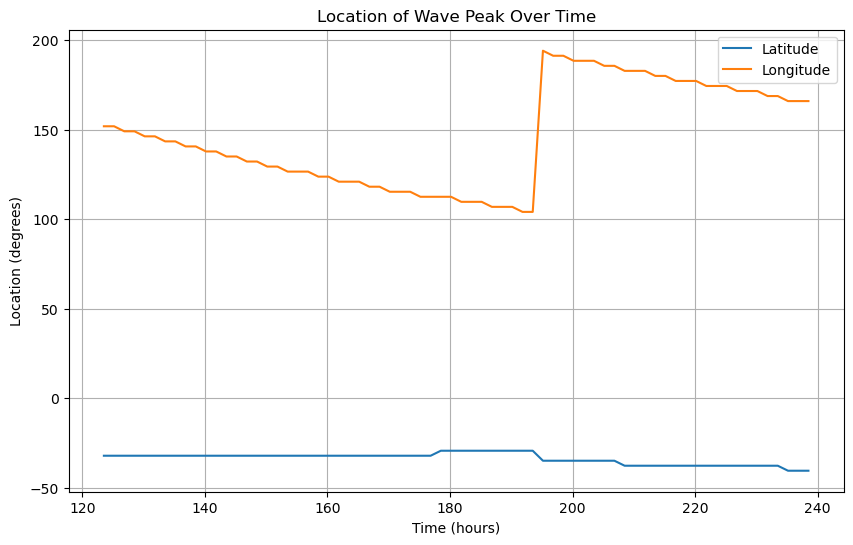

Calculated speeds of the wave peak (km/h):
[      0.          187647.91824754       0.          187647.91824754
       0.          187647.91824754       0.          187647.91824754
       0.          187647.91824754       0.          187647.91824754
       0.          187647.91824754       0.          187647.91824754
       0.          187647.91824754       0.               0.
  187647.91824754       0.          187647.91824754       0.
       0.          187647.91824754       0.          187647.91824754
       0.               0.          187647.91824754       0.
  186185.71629506       0.          187647.91824754       0.
       0.          187647.91824754       0.               0.
  187647.91824754       0.         6016268.20717096  187647.91824754
       0.          187647.91824754       0.               0.
  187647.91824754       0.          264341.58581338       0.
       0.          187647.91824754       0.          187647.91824754
       0.               0.          187647.9182

In [ ]:
# Identify the time index corresponding to 123.50 hours
time_index = np.argmin(np.abs(np.array(t_save) / hour - 123.50))
# Filter out negative latitudes
negative_latitudes = lat[0] < 0
h_save_neg = h_save[:,:, negative_latitudes]
lat_neg = lat[:, negative_latitudes]
# Find the latitude and longitude of the wave peak at this time
peak_long_index, peak_lat_index =np.unravel_index(np.argmax(h_save_neg[time_index, :, :]),h_save_neg[0].shape)
peak_lat = lat_neg[0, peak_lat_index]
peak_long = phi[peak_long_index, 0] * 180 / np.pi  # Convert from radians to degrees

# Calculate the speed of the wave peak by comparing its location at different time steps
peak_locations = []
rossby_time = t_save[time_index:]
for i in range(len(rossby_time)):
    peak_long_index, peak_lat_index = np.unravel_index(np.argmax(h_save_neg[i+time_index, :, :]),h_save_neg[0].shape)
    peak_lat = lat_neg[0, peak_lat_index]
    peak_long = phi[peak_long_index, 0] * 180 / np.pi  # Convert from radians to degrees
    peak_locations.append((peak_lat, peak_long))

# Convert peak locations to numpy array for easier manipulation
peak_locations = np.array(peak_locations)

# Calculate the speed of the wave peak
distances = np.sqrt(np.diff(peak_locations[:, 0])**2 + np.diff(peak_locations[:, 1])**2) * (np.pi / 180) * R
times = np.diff(np.array(rossby_time)) / hour  # Convert time differences to hours
speeds = distances / times  # Speed in km/h

# Plot the location of the wave peak
plt.figure(figsize=(10, 6))
plt.plot(np.array(rossby_time) / hour, peak_locations[:, 0], label='Latitude')
plt.plot(np.array(rossby_time) / hour, peak_locations[:, 1], label='Longitude')
plt.xlabel('Time (hours)')
plt.ylabel('Location (degrees)')
plt.title('Location of Wave Peak Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Print the calculated speeds
print("Calculated speeds of the wave peak (km/h):")
print(speeds)

time_index_120 = np.argmin(np.abs(np.array(rossby_time) / hour - (123.50)))
time_index_180 = np.argmin(np.abs(np.array(rossby_time) / hour - (180)))
print(peak_locations[time_index_180,1])
print(peak_locations[time_index_120,1])

average_wave_speed = (- peak_locations[time_index_180,1] + peak_locations[time_index_120,1]) / (rossby_time[time_index_180] - rossby_time[time_index_120])
average_wave_speed = np.radians(average_wave_speed) * hour
print(f"Average longitude wave speed: {average_wave_speed:.6f} rad per hour")

**The calculated value from the data is close to our prediction for wavespeed. Our prediction is slightly higher, probably due to lack of precision in estimating angular frequency, though also possibly due to the damping effect.**

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?